In [5]:
# ------------------------------------------------------------------------------
# 
#    SurfaceD3 trainer. Use 2 RNNs each with 1 LSTM cell of replication 3.
#
#    Copyright (C) 2017 Pooya Ronagh
# 
# ------------------------------------------------------------------------------

from builtins import range
import numpy as np
import tensorflow as tf
import sys
from util import y2indicator
import threading
import sys
import os
import json
from time import localtime, strftime, clock

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import bayesopt
from bayesoptmodule import BayesOptContinuous, BayesOptDiscrete

# The Surface code generator matrices and look up table
gZ = np.matrix([[1, 0, 0, 1, 0, 0, 0, 0, 0], \
                [0, 1, 1, 0, 1, 1, 0, 0, 0], \
                [0, 0, 0, 1, 1, 0, 1, 1, 0], \
                [0, 0, 0, 0, 0, 1, 0, 0, 1]]).astype(np.int32);
gX = np.matrix([[1, 1, 0, 1, 1, 0, 0, 0, 0], \
                [0, 0, 0, 0, 0, 0, 1, 1, 0], \
                [0, 1, 1, 0, 0, 0, 0, 0, 0], \
                [0, 0, 0, 0, 1, 1, 0, 1, 1]]).astype(np.int32);
XcorrectionMat = np.matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 0, 0, 0, 0, 1], \
                            [0, 0, 0, 0, 0, 0, 1, 0, 0], \
                            [0, 0, 0, 0, 1, 1, 0, 0, 0], \
                            [0, 1, 0, 0, 0, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 0, 1, 0, 0, 0], \
                            [0, 0, 0, 0, 1, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 1, 0, 0, 0, 1], \
                            [1, 0, 0, 0, 0, 0, 0, 0, 0], \
                            [1, 0, 0, 0, 0, 0, 0, 0, 1], \
                            [0, 0, 0, 1, 0, 0, 0, 0, 0], \
                            [0, 0, 0, 1, 0, 0, 0, 0, 1], \
                            [1, 1, 0, 0, 0, 0, 0, 0, 0], \
                            [1, 0, 0, 0, 0, 1, 0, 0, 0], \
                            [1, 0, 0, 0, 1, 0, 0, 0, 0], \
                            [0, 0, 0, 1, 0, 1, 0, 0, 0]]).astype(np.int32);
ZcorrectionMat = np.matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 0, 1, 0, 0, 0], \
                            [0, 0, 1, 0, 0, 0, 0, 0, 0], \
                            [0, 1, 0, 0, 1, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 0, 0, 1, 0, 0], \
                            [0, 0, 0, 0, 0, 0, 0, 1, 0], \
                            [0, 0, 1, 0, 0, 0, 1, 0, 0], \
                            [0, 0, 1, 0, 0, 0, 0, 1, 0], \
                            [1, 0, 0, 0, 0, 0, 0, 0, 0], \
                            [0, 0, 0, 0, 1, 0, 0, 0, 0], \
                            [0, 1, 0, 0, 0, 0, 0, 0, 0], \
                            [0, 1, 0, 0, 0, 1, 0, 0, 0], \
                            [1, 0, 0, 0, 0, 0, 1, 0, 0], \
                            [1, 0, 0, 0, 0, 0, 0, 1, 0], \
                            [0, 1, 0, 0, 0, 0, 1, 0, 0], \
                            [0, 1, 0, 0, 0, 0, 0, 1, 0]]).astype(np.int32);
ZL = np.matrix([[1,0,0,0,1,0,0,0,1]]).astype(np.int32);
XL = np.matrix([[0,0,1,0,1,0,1,0,0]]).astype(np.int32);

err_keys= ['errX3', 'errZ3']
syn_keys= ['synX', 'synZ']

class Data:

    def __init__(self, data):
        self.input= {}
        self.output= {}
        self.output_ind= {}
        self.input['errX3']= data['synX'].reshape(-1, 3, 4)
        self.input['errZ3']= data['synZ'].reshape(-1, 3, 4)
        for key in err_keys:
            self.output[key]= data[key]
        for key in err_keys:
            self.output_ind[key]=y2indicator(data[key],2**9).astype(np.float32)

def io_data_factory(data, test_size):

    train_data_arg = {key:data[key][:-test_size,] for key in data.keys()}
    test_data_arg  = {key:data[key][-test_size:,] for key in data.keys()}
    train_data = Data(train_data_arg)
    test_data = Data(test_data_arg)
    return train_data, test_data

def find_logical_fault(recovery, err, key):

    p_binary= '{0:09b}'.format(recovery)
    t_binary= '{0:09b}'.format(int(err))
    err_list= [int(a!=b) for a, b in zip(p_binary, t_binary)]
    err= np.matrix(err_list).astype(np.int32)
    if (key=='errX3'):
        syndrome= np.dot(gZ, err.transpose()) % 2
        correction_index= np.asscalar(np.dot([[8, 4, 2, 1]], syndrome))
        correction = XcorrectionMat[correction_index,:]
        errFinal = (correction + err) % 2
        logical_err = np.dot(ZL, errFinal.transpose()) % 2
        return logical_err

    elif (key=='errZ3'):
        syndrome= np.dot(gX, err.transpose()) % 2
        correction_index= np.asscalar(np.dot([[8, 4, 2, 1]], syndrome))
        correction = ZcorrectionMat[correction_index,:]
        errFinal = (correction + err) % 2
        logical_err = np.dot(XL, errFinal.transpose()) % 2
        return logical_err

    else: print('Key not recognized.')

def num_logical_fault(prediction, test):

    error_counter= 0.0
    for i in range(len(prediction[err_keys[0]])):
        for key in err_keys:
            if (find_logical_fault(prediction[key][i],test.output[key][i],key)):
                error_counter+=1
                break
    return error_counter/len(prediction[err_keys[0]])

def get_data(filename):

    data= {}
    for key in syn_keys:
        data[key]= []
    for key in err_keys:
        data[key]= []
    with open(filename) as file:
        first_line = file.readline();
        p, lu_avg, lu_std, data_size = first_line.split(' ')
        p= float(p)
        lu_avg= float(lu_avg)
        lu_std= float(lu_std)
        data_size= int(data_size)
        for line in file.readlines():
            line_list= line.split(' ')
            data['synX'].append([bit for bit in ''.join(line_list[0:3])])
            data['synZ'].append([bit for bit in ''.join(line_list[6:9])])
            data['errX3'].append([int(line_list[5],2)])
            data['errZ3'].append([int(line_list[11],2)])
    for key in data.keys():
        data[key]= np.array(data[key]).astype(np.float32)
    return data, p, lu_avg, lu_std, data_size

def train(param, train_data, test_data, \
          num_classes, num_inputs, input_size, n_batches):

    prediction= {}
    verbose= param['usr']['verbose']
    batch_size= param['opt']['batch size']
    learning_rate= param['opt']['learning rate']
    num_iterations= param['opt']['iterations']
    momentum_val= param['opt']['momentum']
    decay_rate= param['opt']['decay']
    num_hidden= param['nn']['num hidden'] 
    W_std= param['nn']['W std'] 
    b_std= param['nn']['b std'] 

    # define all parts of the tf graph
    tf.reset_default_graph()
    x = {}
    y = {}
    lstm = {}
    lstmOut = {}
    W= {}
    b= {}
    logits= {}
    loss= {}
    predict= {}
    
    for key in err_keys:
        with tf.variable_scope(key):

            x[key] = tf.placeholder(tf.float32, [None, num_inputs, input_size])
            y[key] = tf.placeholder(tf.float32, [None, num_classes])
            lstm[key] = tf.contrib.rnn.LSTMCell(num_hidden)
            lstmOut[key], _ = tf.nn.dynamic_rnn(\
                lstm[key], x[key], dtype=tf.float32)
            W[key]= tf.Variable(\
                tf.random_normal([num_hidden,num_classes], stddev=W_std))
            b[key]= tf.Variable(tf.random_normal([num_classes], stddev=b_std))
            logits[key]= tf.matmul(lstmOut[key][:,-1,:], W[key]) + b[key]
            loss[key]= tf.nn.softmax_cross_entropy_with_logits(\
                logits=logits[key], labels=y[key])
            predict[key]= tf.argmax(logits[key], 1)
    
    cost= tf.reduce_sum(sum(loss[key] for key in err_keys))
    train = tf.train.RMSPropOptimizer(\
        learning_rate, decay=decay_rate, momentum=momentum_val).minimize(cost)
    init = tf.global_variables_initializer()
    costs= []

    with tf.Session() as session:
        if (verbose): print('session begins '),
        session.run(init)

        for i in range(num_iterations):
            if (verbose): print('.'),

            for j in range(n_batches):
                beg= j * batch_size
                end= j * batch_size + batch_size
                feed_dict={}
                for key in err_keys:
                    feed_dict[x[key]]= train_data.input[key][beg:end,]
                    feed_dict[y[key]]= train_data.output_ind[key][beg:end,]
                session.run(train, feed_dict)
            
            if (verbose>1):
                feed_dict={}
                for key in err_keys:
                    feed_dict[x[key]]= test_data.input[key]
                    feed_dict[y[key]]= test_data.output_ind[key]
                test_cost = session.run(cost, feed_dict)
                costs.append(test_cost)

        for key in err_keys:
            prediction[key] = session.run(predict[key], \
                feed_dict= {x[key]: test_data.input[key]})
        if (verbose): print(' session ends.')

    if (verbose>1):
        plt.plot(costs)
        plt.show()
        
    return num_logical_fault(prediction, test_data)

class BayesOptTest(BayesOptContinuous):

    def __init__(self, N, filename, param,\
            raw_data, p, lu_avg, lu_std, data_size):
        super(BayesOptTest, self).__init__(N)
        self.filename= filename
        self.param= param
        self.raw_data= raw_data
        self.p= p
        self.lu_avg= lu_avg
        self.lu_std= lu_std
        self.data_size= data_size

        self.test_fraction= self.param['data']['test fraction']
        self.total_size= np.shape(self.raw_data['synX'])[0]
        self.test_size= int(self.test_fraction * self.total_size)
        self.train_data, self.test_data = \
            io_data_factory(self.raw_data, self.test_size)

        self.batch_size= self.param['opt']['batch size']
        self.train_size= self.total_size - self.test_size
        self.n_batches = self.train_size // self.batch_size
        self.error_scale= 1.0*self.total_size/self.data_size

        self.num_classes= 2**9
        self.num_inputs= 3
        self.input_size= 4

    def evaluateSample(self, x):
        
        print('new sample='+ str(x))
#         self.param['opt']['batch size']= int(x[0] * 100) 
        self.param['opt']['learning rate']= 10**x[0] 
#         self.param['opt']['iterations']= int(x[2] * 10)
#         self.param['opt']['momentum']= x[1] 
#         self.param['opt']['decay']= x[2]
#         self.param['nn']['num hidden']= int(x[3] * 10)
        self.param['nn']['W std']= 10**x[1]
#         self.param['nn']['b std']= 10**x[3]

        avg = train(self.param, self.train_data, self.test_data, \
            self.num_classes, self.num_inputs, self.input_size, self.n_batches)
        print('result= '+ str(self.error_scale * avg))
        return self.error_scale * avg

# Run an entire benchmark  
1. learning rate= 10**x[1] 
2. momentum= x[3] 
3. decay= x[4]
4. num hidden= int(x[5] * 10)
5. W std= 10**x[6]

In [7]:
param= {}
param['nn']= {}
param['opt']= {}
param['data']= {}
param['usr']= {}
param['nn']['num hidden']= 500
param['opt']['batch size']= 1000
param['data']['test fraction']= 0.1
param['opt']['iterations']= 30
param['usr']['verbose']= 0

x= [-5.69398902, 0.9, 0.9, 50., -2.14472344]
param['opt']['learning rate']= 10**x[0]
param['opt']['momentum']= x[1] 
param['opt']['decay']= x[2]
param['nn']['num hidden']= int(x[3] * 10)
param['nn']['W std']= 10**x[4]
param['nn']['b std']= 0.0

output= []
num_classes= 2**9
num_inputs= 3
input_size= 4
verbose= param['usr']['verbose']

datafolder= '../SurfaceData/e-04/'
file_list= os.listdir(datafolder)

for filename in file_list:
    # Read data and find how much null syndromes to assume for error_scale
    print("Reading data from " + filename)
    raw_data, p, lu_avg, lu_std, data_size = get_data(datafolder + filename)

    test_fraction= param['data']['test fraction']
    total_size= np.shape(raw_data['synX'])[0]
    test_size= int(test_fraction * total_size)
    train_data, test_data = io_data_factory(raw_data, test_size)

    batch_size= param['opt']['batch size']
    train_size= total_size - test_size
    n_batches = train_size // batch_size
    error_scale= 1.0*total_size/data_size

    avg= train(param, train_data, test_data, \
        num_classes, num_inputs, input_size, n_batches)

    run_log= {}
    run_log['data']= {}
    run_log['opt']= {}
    run_log['res']= {}
    run_log['data']['path']= filename
    run_log['data']['fault scale']= error_scale
    run_log['data']['total data size']= total_size
    run_log['data']['test set size']= test_size
    run_log['opt']['batch size']= batch_size
    run_log['opt']['number of batches']= n_batches
    run_log['res']['p']= p
    run_log['res']['lu avg']= lu_avg
    run_log['res']['lu std']= lu_std
    run_log['res']['nn avg'] = error_scale * avg
    run_log['res']['nn std'] = 0
    output.append(run_log)
    
    if (verbose):
        print('fault rate= '+str(error_scale * avg))

outfilename = strftime("%Y-%m-%d-%H-%M-%S", localtime())
f = open('../Reports/SurfaceD3/' + outfilename + '.json', 'w')
f.write(json.dumps(output, indent=2))
f.close()

Reading data from SyndromeAndError1.000e-04.txt
Reading data from SyndromeAndError2.000e-04.txt
Reading data from SyndromeAndError3.000e-04.txt
Reading data from SyndromeAndError4.000e-04.txt
Reading data from SyndromeAndError5.000e-04.txt
Reading data from SyndromeAndError6.000e-04.txt
Reading data from SyndromeAndError7.000e-04.txt
Reading data from SyndromeAndError8.000e-04.txt


### Run hypertuning on the single file.

0. 1. batch size= int(x[0] * 100) 
1. 2. learning rate= 10**x[1] 
0. 3. iterations= int(x[2] * 10)
2. 4. momentum= x[3] 
3. 5. decay= x[4]
4. 6. num hidden= int(x[5] * 10)
5. 7. W std= 10**x[6]
0. 8. b std= 10**x[7]

lb = np.array([1., -6., 1., .8, .8, 5., -4., -4.])

ub = np.array([20., 1., 10., 0.999, .999, 150., 1., 1.])

new sample=[-4.91653518 -3.52344308]
session begins  . . . . . . . . . . . . . . . . . . . .  session ends.


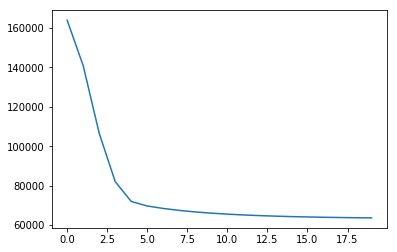

0.0327226516997
result= 0.00123600327227
new sample=[-5.69398902 -2.14472344]
session begins  . . . . . . . . . . . . . . . . . . . .  session ends.


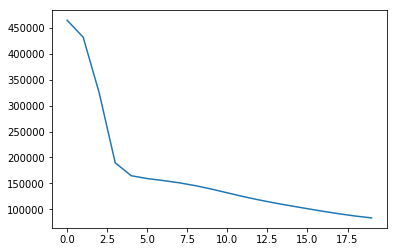

0.00386529704543
result= 0.00014600038653
new sample=[-4. -2.]
session begins  . . . . . . . . . . . . . . . . . . . .  session ends.


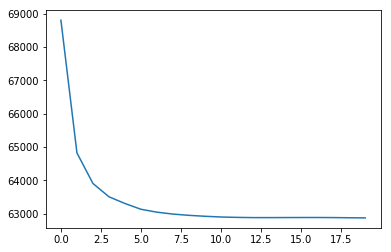

0.031954887218
result= 0.00120700319549
new sample=[-6. -4.]
session begins  . . . . . . .

RuntimeError: 

In [4]:
lb = np.array([-6.0, -4.0])
ub = np.array([-4.0, -2.0])

param= {}
param['nn']= {}
param['opt']= {}
param['data']= {}
param['usr']= {}
param['nn']['num hidden']= 500
param['nn']['W std']= 0.0
param['nn']['b std']= 0.0
param['opt']['batch size']= 1000
param['opt']['learning rate']= 10e-6
param['opt']['iterations']= 20
param['opt']['momentum']= 0.9
param['opt']['decay']= 0.9
param['data']['test fraction']= 0.1
param['usr']['verbose']= 2

datafolder= '../SurfaceData/e-04/'
filename= 'SyndromeAndError2.000e-04.txt'
raw_data, p, lu_avg, lu_std, data_size = get_data(datafolder + filename)

engine = BayesOptTest(len(lb), datafolder + filename, param,\
    raw_data, p, lu_avg, lu_std, data_size)

hyperparam = {}
hyperparam['n_iterations'] = 50
hyperparam['n_iter_relearn'] = 5
hyperparam['n_init_samples'] = 2
hyperparam['noise']= 1e-10
# hyperparam['l_type']= 'L_MCMC'
hyperparam['kernel_name'] = "kMaternARD5"
hyperparam['kernel_hp_mean'] = [1]
hyperparam['kernel_hp_std'] = [5]
hyperparam['surr_name'] = "sStudentTProcessNIG"
#hyperparam['crit_name'] = "cMI"

engine.parameters = hyperparam
engine.lower_bound = lb
engine.upper_bound = ub
start = clock()
mvalue, x_out, error = engine.optimize()
print("Result", mvalue, "at", x_out)
print("Running time:", clock() - start, "seconds")